# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [2]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn
import psycopg2 as psy
import csv
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.decomposition import PCA 
import pandas as pd
from pandas.io import sql
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt


#### Step 2: Examine your data 

In [3]:
cancel = pd.read_csv("/Users/EKandTower/GA-DSI/projects/projects-weekly/project-07/\
assets/airport_cancellations.csv")

ops = pd.read_csv("/Users/EKandTower/GA-DSI/projects/projects-weekly/project-07/\
assets/Airport_operations.csv")

ap = pd.read_csv("/Users/EKandTower/GA-DSI/projects/projects-weekly/project-07/\
assets/airports.csv")

# ajbentley

# apdat = pd.read_csv("/Users/EKandTower/GA-DSI/projects/projects-weekly/project-07/\
# assets/airportsdat.csv")


In [4]:
cancel.head(3)

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0


In [5]:
ops.head(3)

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82


In [6]:
ap.head(3)

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes


In [7]:
cancel.info()

# should change Airport to key in Airports DB so these are all numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 6 columns):
Airport                    805 non-null object
Year                       805 non-null float64
Departure Cancellations    805 non-null float64
Arrival Cancellations      805 non-null float64
Departure Diversions       805 non-null float64
Arrival Diversions         805 non-null float64
dtypes: float64(5), object(1)
memory usage: 37.8+ KB


In [9]:
ops.info()

# should change Airport to key in Airports DB so these are all numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 15 columns):
airport                               841 non-null object
year                                  841 non-null int64
departures for metric computation     841 non-null int64
arrivals for metric computation       841 non-null int64
percent on-time gate departures       841 non-null float64
percent on-time airport departures    841 non-null float64
percent on-time gate arrivals         841 non-null float64
average_gate_departure_delay          841 non-null float64
average_taxi_out_time                 841 non-null float64
average taxi out delay                841 non-null float64
average airport departure delay       841 non-null float64
average airborne delay                841 non-null float64
average taxi in delay                 841 non-null float64
average block delay                   841 non-null float64
average gate arrival delay            841 non-null float64
dtypes: float64(1

In [10]:
ap.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5167 entries, 0 to 5166
Data columns (total 13 columns):
Key                        5164 non-null float64
LocID                      5152 non-null object
AP_NAME                    5164 non-null object
ALIAS                      3498 non-null object
Facility Type              5164 non-null object
FAA REGION                 5164 non-null object
COUNTY                     5164 non-null object
CITY                       5164 non-null object
STATE                      5164 non-null object
AP Type                    5164 non-null object
Latitude                   5164 non-null float64
Longitude                  5164 non-null float64
Boundary Data Available    5164 non-null object
dtypes: float64(3), object(10)
memory usage: 524.8+ KB


### Intro: Write a problem statement / aim for this project

Several ways to consider these questions.

FAA wants to cut down on delays nationwide--do we need to consider int'l delays? Seems like data is set up on national so no need to do more on this.


Inspect delay times, each type individually as functions of total depart/arrive, departure combined, arrival combined, by airport by year. This will allow us to ID which airports are the biggest problems and which have not been improving.

Probably a stretch, but can we include a slope number as a column to indicate the airport's change in delays over the past 10 years and past 3 years?

These would be really strong indicators in terms of what airports need to be addressed. If we can do this then we can cluster using just the numbers from the current year.

Clusters should show what airports have higher than normal delay times and whose operations have been flat or worsening.

Once we ID what airports are the problems we can figure out what they have in common. Will probably look at lat/long, faa region, capacity




You've been hired by the FAA as a consultant to analyze the operations of major airports around the country. The FAA wants to cut down on delays nationwide, and the most important part of this task is understanding the characteristics and groupings of airports based on a dataset of departure and operational delays.

A certain degree of delay is expected in airport operations, however the FAA is noticing significant delays with certain airports
When a flight takes off, it's departure delay is recorded in minutes, as well as operational data relating to this delay
At the end of the year, this data is averaged out for each airport. Your datasets have these averaged for a 10 year range between 2004 and 2014
Over this 10 year range, some delay times have not improved or have worsened.
Objective: Your task is to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.



### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [11]:
# import sqlite3
# sqlite_db = 'dsi2-db.sqlite'
# conn = sqlite3.connect(sqlite_db)
# c = conn.cursor()

# print "done"

In [12]:
# con = None
# con = psy.connect(database='Default', user='postgres') 

In [13]:
# engine = create_engine('postgresql://localhost:5432/apdb')
# cancel.to_sql('cancel', engine, if_exists='replace')
# operations.to_sql('ops', engine, if_exists='replace')
# apdb.to_sql('apdb', engine, if_exists='replace')
# %load_ext sql


Load our csv files into tables

In [14]:
cancel.rename(columns ={'Airport':'AP_NAME'}, inplace=True)

In [15]:
cancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 6 columns):
AP_NAME                    805 non-null object
Year                       805 non-null float64
Departure Cancellations    805 non-null float64
Arrival Cancellations      805 non-null float64
Departure Diversions       805 non-null float64
Arrival Diversions         805 non-null float64
dtypes: float64(5), object(1)
memory usage: 37.8+ KB


Join airport_cancellations.csv and airports.csv into one table

In [16]:
df = cancel.join(ap, rsuffix='ap')


In [17]:
df = df.join(ops, rsuffix='ops')


Query the database for our intial data

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 34 columns):
AP_NAME                               805 non-null object
Year                                  805 non-null float64
Departure Cancellations               805 non-null float64
Arrival Cancellations                 805 non-null float64
Departure Diversions                  805 non-null float64
Arrival Diversions                    805 non-null float64
Key                                   805 non-null float64
LocID                                 804 non-null object
AP_NAMEap                             805 non-null object
ALIAS                                 631 non-null object
Facility Type                         805 non-null object
FAA REGION                            805 non-null object
COUNTY                                805 non-null object
CITY                                  805 non-null object
STATE                                 805 non-null object
AP Type            

#### 1.2 What are the risks and assumptions of our data? 

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [19]:
df.describe()

,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,Latitude,Longitude,year,departures for metric computation,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,...,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,2008.986335,1292.038509,1333.124224,173.315528,169.413665,2488.650932,30.522748,-93.577507,2009.014907,111331.108075,...,0.719039,0.760144,13.299888,13.813453,3.604907,16.059615,2.930112,1.385006,3.322807,13.743565
std,3.158116,1835.961943,1975.224868,172.345539,228.521615,1607.433809,2.806227,12.880292,3.152394,99041.431112,...,0.088554,0.068339,4.076106,3.836060,2.397139,4.937230,1.199621,0.879909,1.029183,3.907379
min,2004.000000,0.000000,0.000000,0.000000,0.000000,254.000000,17.701556,-177.381308,2004.000000,261.000000,...,0.245700,0.349500,5.350000,7.040000,0.000000,6.290000,0.950000,0.000000,1.230000,6.330000
25%,2006.000000,349.000000,314.000000,62.000000,41.000000,880.000000,29.607333,-97.969472,2006.000000,39279.000000,...,0.686300,0.738100,10.950000,11.330000,2.230000,12.980000,2.060000,0.820000,2.630000,11.270000
50%,2009.000000,663.000000,642.000000,110.000000,84.000000,2900.000000,31.179278,-93.745023,2009.000000,73741.000000,...,0.736200,0.769300,12.670000,12.930000,3.030000,15.240000,2.660000,1.120000,3.150000,13.070000
75%,2012.000000,1472.000000,1523.000000,236.000000,190.000000,3319.000000,32.493417,-84.557425,2012.000000,166455.000000,...,0.770700,0.797500,14.820000,15.720000,4.190000,17.850000,3.620000,1.770000,3.850000,15.190000
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,5251.000000,33.303458,-64.801722,2014.000000,491826.000000,...,0.897400,0.880300,40.800000,35.760000,18.940000,40.870000,7.820000,6.180000,7.520000,34.280000


In [20]:
df.head()

,AP_NAME,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,LocID,AP_NAMEap,ALIAS,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,5088.0,X64,PATILLAS,NaN,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [21]:
df.isnull().sum()

AP_NAME                                 0
Year                                    0
Departure Cancellations                 0
Arrival Cancellations                   0
Departure Diversions                    0
Arrival Diversions                      0
Key                                     0
LocID                                   1
AP_NAMEap                               0
ALIAS                                 174
Facility Type                           0
FAA REGION                              0
COUNTY                                  0
CITY                                    0
STATE                                   0
AP Type                                 0
Latitude                                0
Longitude                               0
Boundary Data Available                 0
airport                                 0
year                                    0
departures for metric computation       0
arrivals for metric computation         0
percent on-time gate departures   

In [22]:
df.pop('Key');

In [23]:
df.groupby(['Year']).agg(['count'])

,AP_NAME,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,LocID,AP_NAMEap,ALIAS,Facility Type,FAA REGION,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
,count,count,count,count,count,count,count,count,count,count,...,count,count,count,count,count,count,count,count,count,count
Year,,,,,,,,,,,,,,,,,,,,,
2004.0,73,73,73,73,73,73,73,56,73,73,...,73,73,73,73,73,73,73,73,73,73
2005.0,73,73,73,73,73,73,73,56,73,73,...,73,73,73,73,73,73,73,73,73,73
2006.0,74,74,74,74,74,74,74,61,74,74,...,74,74,74,74,74,74,74,74,74,74
2007.0,74,74,74,74,74,74,74,55,74,74,...,74,74,74,74,74,74,74,74,74,74
2008.0,74,74,74,74,74,74,74,58,74,74,...,74,74,74,74,74,74,74,74,74,74
2009.0,73,73,73,73,73,73,73,58,73,73,...,73,73,73,73,73,73,73,73,73,73
2010.0,73,73,73,73,73,72,73,58,73,73,...,73,73,73,73,73,73,73,73,73,73
2011.0,73,73,73,73,73,73,73,62,73,73,...,73,73,73,73,73,73,73,73,73,73


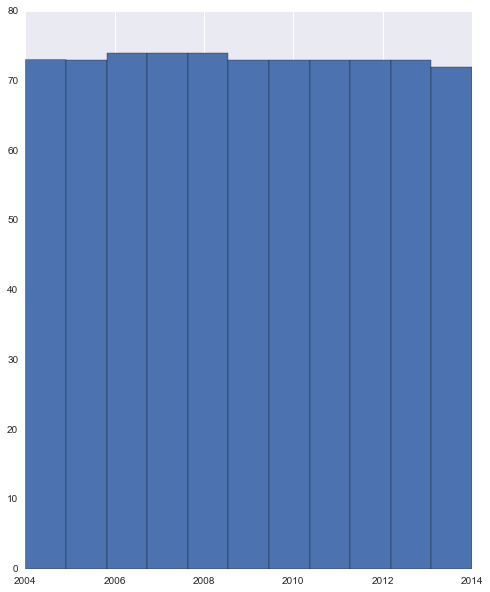

In [24]:
df['Year'].hist(figsize=(8,10), bins=11)

In [25]:
# making new db with only 2014 data. As indicated at the head of this document, my preferred analysis on this would\
# to just use 2014 and the change metrics. I think prior years' data are useful mostly for the change.


df14 = pd.DataFrame(df.loc[df['Year'] == 2014])
df14.head()

,AP_NAME,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,LocID,AP_NAMEap,ALIAS,Facility Type,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
10,ABQ,2014.0,315.0,274.0,66.0,37.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,...,0.7148,0.7320,14.30,10.64,2.41,15.99,1.73,1.02,2.40,14.72
21,ANC,2014.0,111.0,162.0,74.0,28.0,MKK,MOLOKAI,Molokai Airport,Airport,...,0.8074,0.8600,11.33,11.33,1.33,12.34,4.09,0.54,4.57,10.82
32,ATL,2014.0,5977.0,6483.0,781.0,655.0,X44,MIAMI,NaN,Airport,...,0.7134,0.8123,11.99,17.40,4.92,15.93,2.74,2.77,3.21,12.42
43,AUS,2014.0,484.0,435.0,88.0,97.0,PIL,PORT ISABEL-CAMERON COUNTY,Port Isabel-Cameron County Airport,Airport,...,0.7382,0.7222,14.16,11.76,2.06,15.59,2.25,1.08,2.88,16.20
54,BDL,2014.0,467.0,421.0,57.0,32.0,T05,CHARLES R JOHNSON,NaN,Airport,...,0.7605,0.7569,12.64,12.76,2.58,14.39,2.34,0.95,2.64,14.79


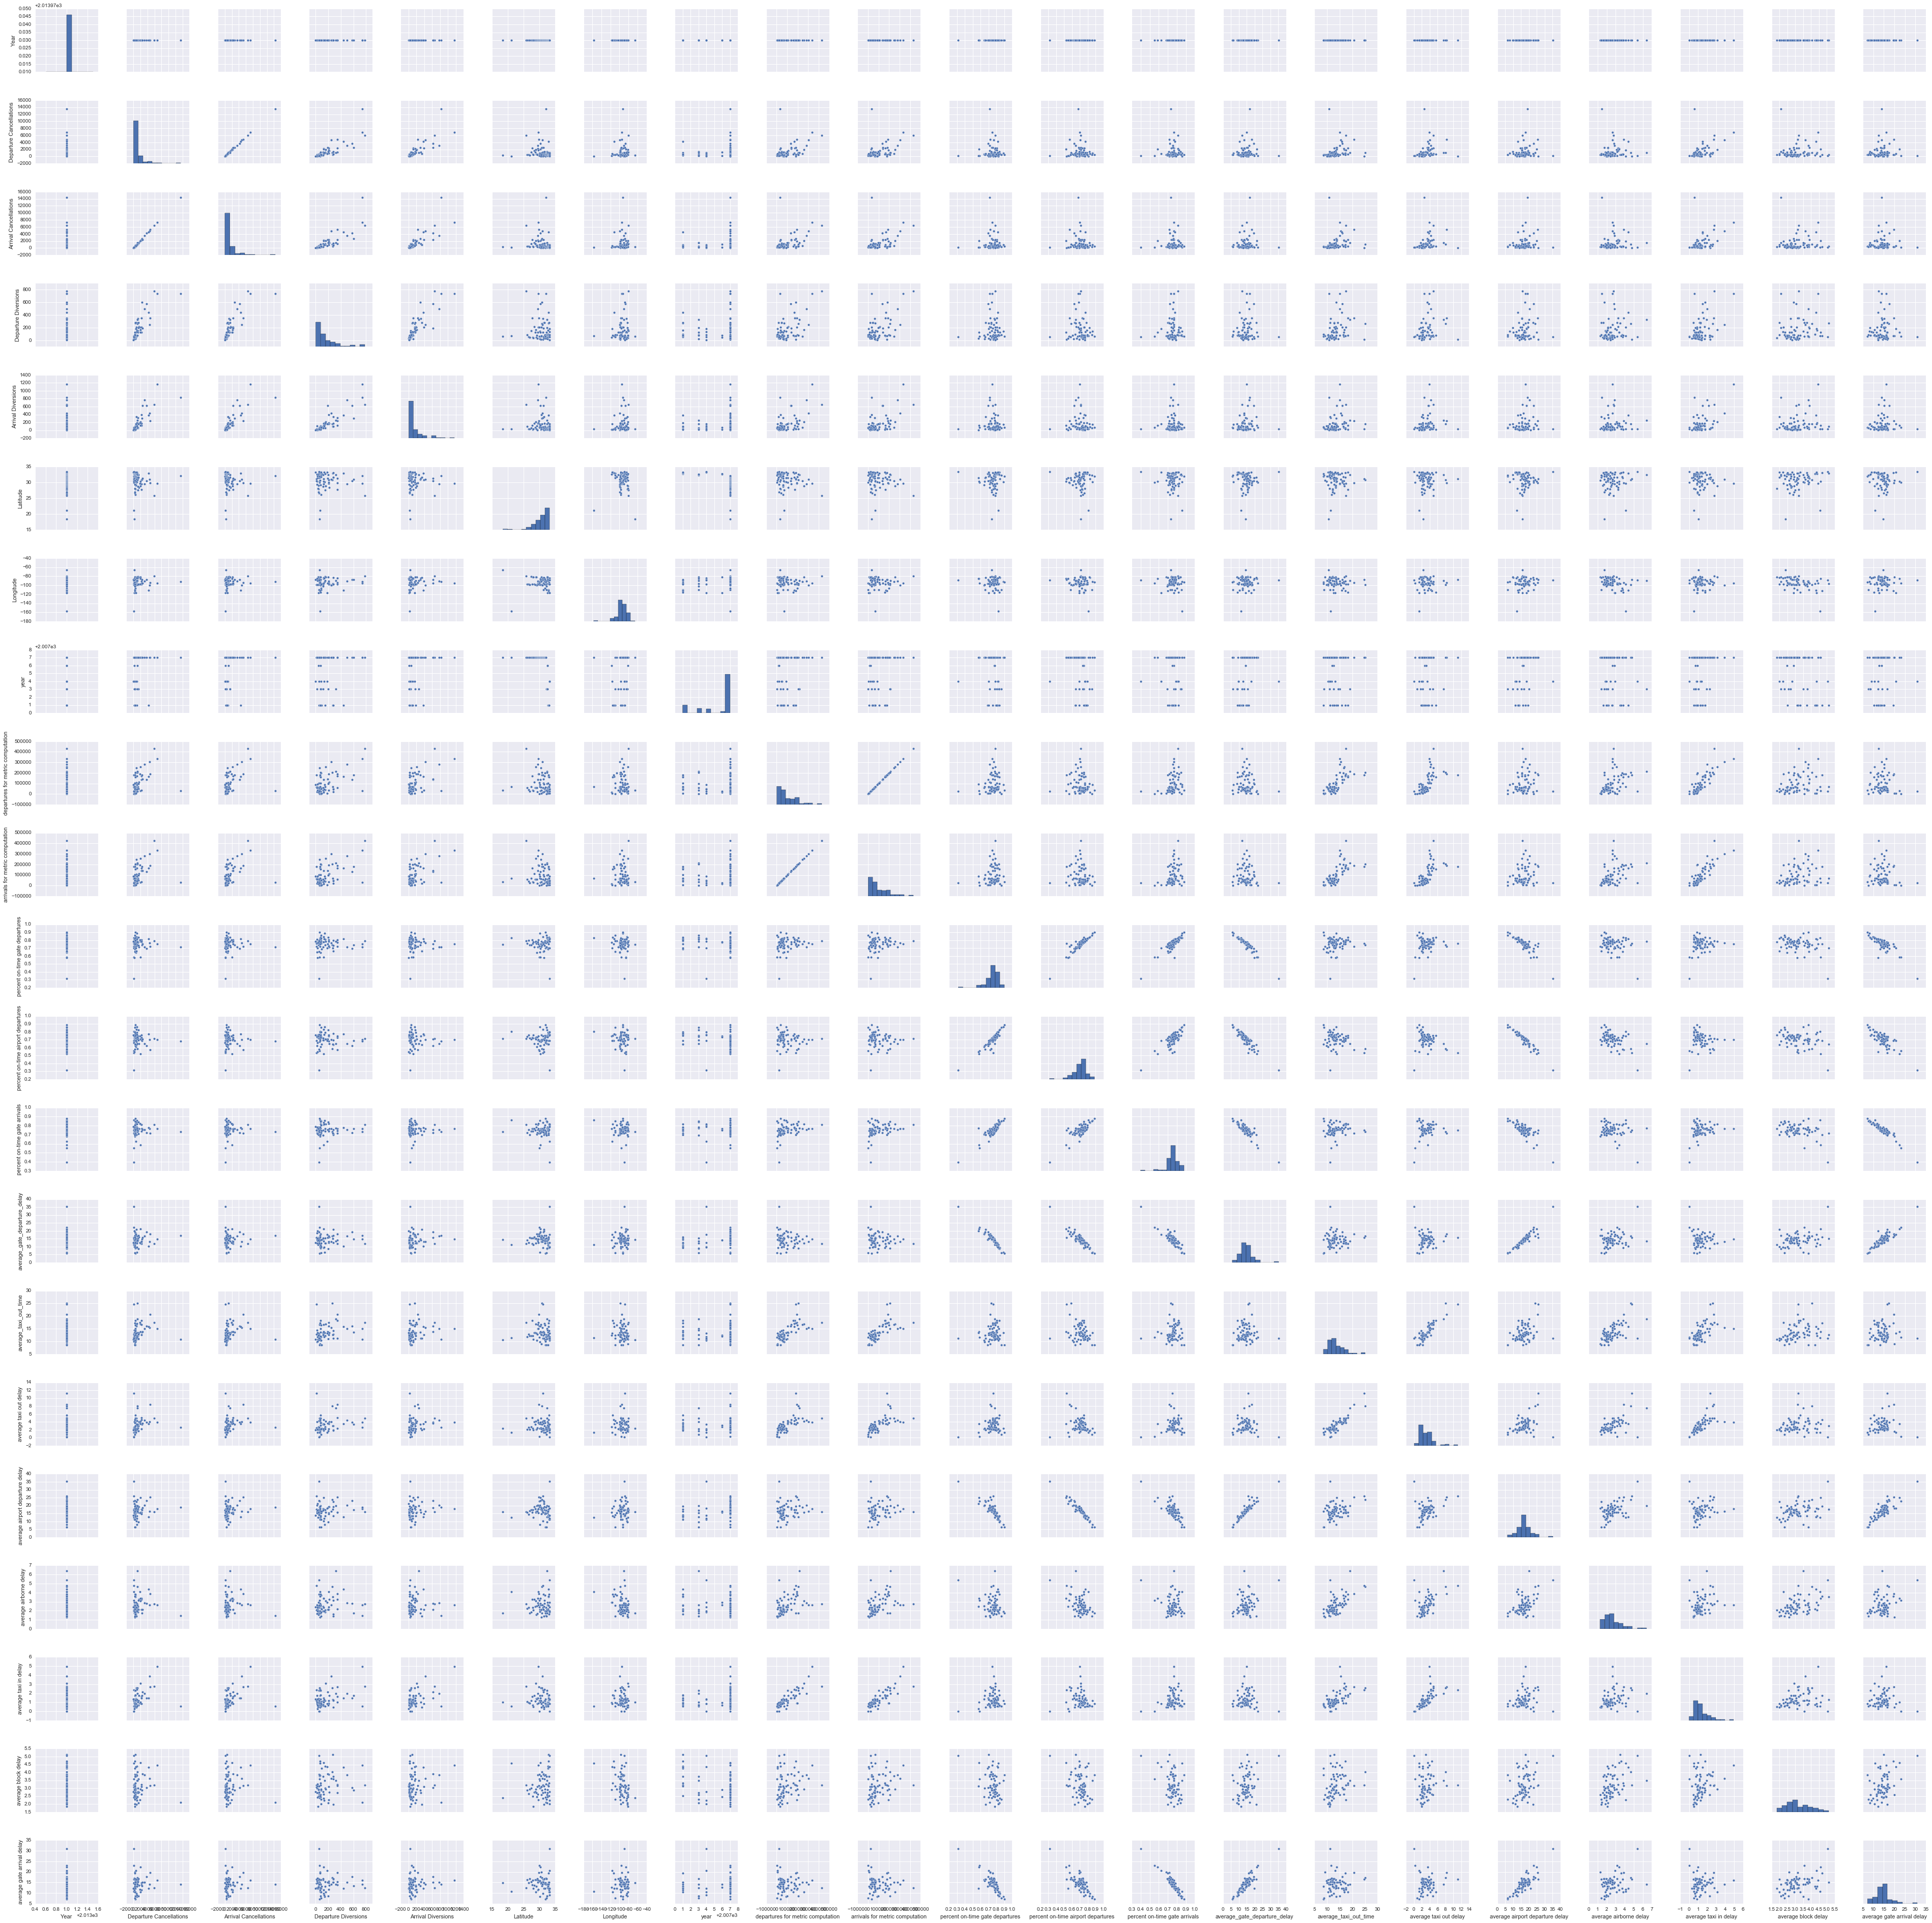

In [26]:
sns.pairplot(df14, kind="scatter")

#### Are there any unique values? 

In [27]:
df.rename(columns ={'AP Type':'AP_Type'}, inplace=True)
df.rename(columns ={'Facility Type':'Fac_Type'}, inplace=True)

In [28]:
df.AP_Type.unique()

array(['Public Use', 'Federalized/Commercial'], dtype=object)

In [29]:
df.Fac_Type.unique()

array(['Airport'], dtype=object)

In [30]:
df.pop('Fac_Type')
df.pop('AP_NAMEap');

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

In [31]:
region_dummy = pd.get_dummies(df['FAA REGION'], prefix='Region')

df = df.join(region_dummy)

df.head()

,AP_NAME,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,LocID,ALIAS,FAA REGION,COUNTY,...,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Region_ASO,Region_ASW,Region_AWP
0,ABQ,2004.0,242.0,235.0,71.0,46.0,STX,Henry E Rohlsen Int'l Airport,ASO,-VIRGIN ISLANDS-,...,9.89,2.43,12.10,2.46,0.83,2.55,10.87,1.0,0.0,0.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0,X64,NaN,ASO,#NAME?,...,9.79,2.29,11.20,2.26,0.89,2.34,10.24,1.0,0.0,0.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0,PSE,Aeropuerto Mercedita,ASO,#NAME?,...,9.89,2.16,12.33,2.12,0.84,2.66,11.82,1.0,0.0,0.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0,VQS,Aeropuerto Antonio Rivera Rodr�guez,ASO,#NAME?,...,10.34,2.40,12.95,2.19,1.29,3.06,12.71,1.0,0.0,0.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0,X63,Aeropuerto Regional De Humacao,ASO,#NAME?,...,10.41,2.41,12.32,1.82,1.03,2.79,11.48,1.0,0.0,0.0


#### 3.2 Format and Clean the Data

In [32]:
# create slopes

    

In [33]:
# df.pop('ALIAS')
# df.pop('COUNTY')
# df.pop('CITY')
# df.pop('STATE')
# df.pop('Boundary Data Available')
# df.pop('year')
# df.pop('airport');

In [34]:
# df.columns = ['airport','year','DCancel','ACancel','DDivert','ADivert','LocID','region','ap_type','Lat','Long','deps'\
#               ,'arr','pct_ont_gateD','pct_ont_airptD','pct_ont_gateA','avg_gate_Ddelay','avg_taxi_out',\
#               'avg_taxi_delay','avg_airptDdelay','avg_airborne_delay','avg_taxi_in_delay','avg_block_delay',\
#               'avg_gate_Adelay','Region_ASO','Region_ASW','Region_AWP']
# df.head()

In [35]:
df14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 10 to 804
Data columns (total 33 columns):
AP_NAME                               72 non-null object
Year                                  72 non-null float64
Departure Cancellations               72 non-null float64
Arrival Cancellations                 72 non-null float64
Departure Diversions                  72 non-null float64
Arrival Diversions                    72 non-null float64
LocID                                 72 non-null object
AP_NAMEap                             72 non-null object
ALIAS                                 51 non-null object
Facility Type                         72 non-null object
FAA REGION                            72 non-null object
COUNTY                                72 non-null object
CITY                                  72 non-null object
STATE                                 72 non-null object
AP Type                               72 non-null object
Latitude                           

In [36]:
# create more manageable list for visualizations 
dfn = ['Departure Cancellations','Arrival Cancellations','Departure Diversions','Arrival Diversions','Latitude'\
       ,'Longitude','departures for metric computation','arrivals for metric computation',\
       'percent on-time gate departures', 'percent on-time airport departures','percent on-time gate arrivals',\
       'average_taxi_out_time','average taxi out delay','average airport departure delay','average airborne delay',\
       'average taxi in delay','average block delay','average gate arrival delay' ]
dfn = pd.DataFrame(df14[dfn])
dfn.head()

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Latitude,Longitude,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
10,315.0,274.0,66.0,37.0,18.439295,-66.002004,33292,33137,0.7451,0.7148,0.7320,10.64,2.41,15.99,1.73,1.02,2.40,14.72
21,111.0,162.0,74.0,28.0,21.152886,-157.096256,71099,66704,0.8288,0.8074,0.8600,11.33,1.33,12.34,4.09,0.54,4.57,10.82
32,5977.0,6483.0,781.0,655.0,25.778333,-80.170278,428954,428312,0.7899,0.7134,0.8123,17.40,4.92,15.93,2.74,2.77,3.21,12.42
43,484.0,435.0,88.0,97.0,26.166194,-97.345889,60588,60264,0.7627,0.7382,0.7222,11.76,2.06,15.59,2.25,1.08,2.88,16.20
54,467.0,421.0,57.0,32.0,26.562843,-97.437759,39279,39109,0.7953,0.7605,0.7569,12.76,2.58,14.39,2.34,0.95,2.64,14.79


### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

In [37]:
dfn.describe()

,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Latitude,Longitude,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,1372.652778,1413.902778,171.111111,163.458333,30.596586,-94.599805,99313.375000,98989.277778,0.752960,0.704911,0.751256,13.524861,3.183472,16.863333,2.660000,1.335833,3.200694,14.472778
std,1997.878573,2149.679014,178.508733,217.219493,2.644913,12.238074,88534.604766,88426.863627,0.081974,0.088062,0.070395,3.256936,1.814836,4.616593,0.981281,0.853547,0.770649,3.759929
min,17.000000,11.000000,3.000000,7.000000,18.439295,-157.096256,729.000000,752.000000,0.318500,0.317000,0.398200,8.520000,0.110000,6.440000,1.260000,0.000000,1.840000,7.180000
25%,428.000000,388.250000,56.500000,34.750000,29.625690,-98.434040,34276.250000,33970.750000,0.722600,0.670500,0.722800,11.245000,2.102500,14.295000,1.967500,0.837500,2.637500,12.280000
50%,633.000000,643.000000,88.000000,82.500000,31.175144,-94.225836,64522.000000,64461.000000,0.767050,0.716000,0.755100,12.765000,2.615000,16.475000,2.440000,1.150000,3.080000,14.550000
75%,1365.250000,1489.250000,211.500000,176.500000,32.487121,-87.164354,161125.250000,159243.750000,0.796575,0.753750,0.782650,15.117500,3.962500,19.157500,3.130000,1.732500,3.767500,16.225000
max,13454.000000,14355.000000,781.000000,1164.000000,33.303458,-66.002004,428954.000000,428312.000000,0.900700,0.888100,0.878400,25.100000,11.210000,35.400000,6.410000,4.950000,5.130000,30.940000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13f43ead0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x150689b50>]], dtype=object)

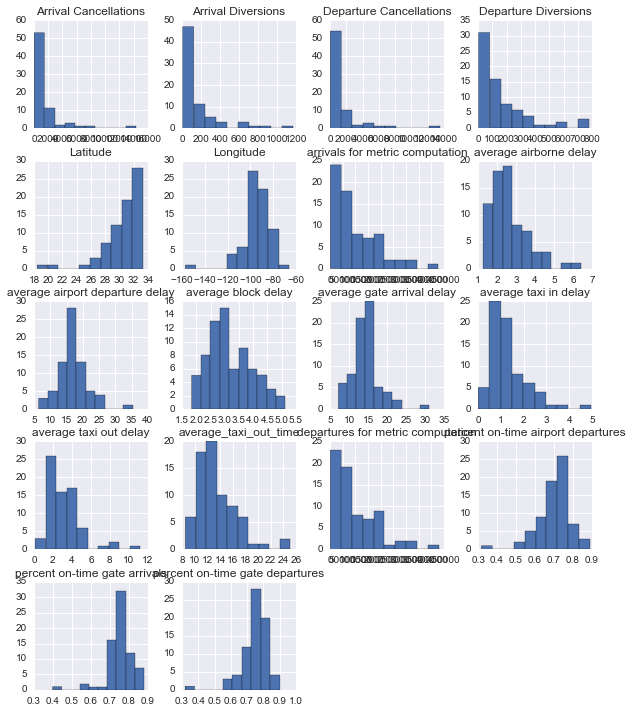

In [38]:
dfn.hist(figsize=(10,12))

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 34 columns):
AP_NAME                               805 non-null object
Year                                  805 non-null float64
Departure Cancellations               805 non-null float64
Arrival Cancellations                 805 non-null float64
Departure Diversions                  805 non-null float64
Arrival Diversions                    805 non-null float64
LocID                                 804 non-null object
ALIAS                                 631 non-null object
FAA REGION                            805 non-null object
COUNTY                                805 non-null object
CITY                                  805 non-null object
STATE                                 805 non-null object
AP_Type                               805 non-null object
Latitude                              805 non-null float64
Longitude                             805 non-null float64
Boundary Data Avai

#### 4.2 Find correlations in the data

In [40]:
print dfn.corr()

                                    Departure Cancellations  \
Departure Cancellations                            1.000000   
Arrival Cancellations                              0.998869   
Departure Diversions                               0.814193   
Arrival Diversions                                 0.815058   
Latitude                                          -0.038082   
Longitude                                          0.090160   
departures for metric computation                  0.412886   
arrivals for metric computation                    0.412948   
percent on-time gate departures                    0.001853   
percent on-time airport departures                -0.063333   
percent on-time gate arrivals                      0.051384   
average_taxi_out_time                              0.186542   
average taxi out delay                             0.210018   
average airport departure delay                    0.123237   
average airborne delay                            -0.00

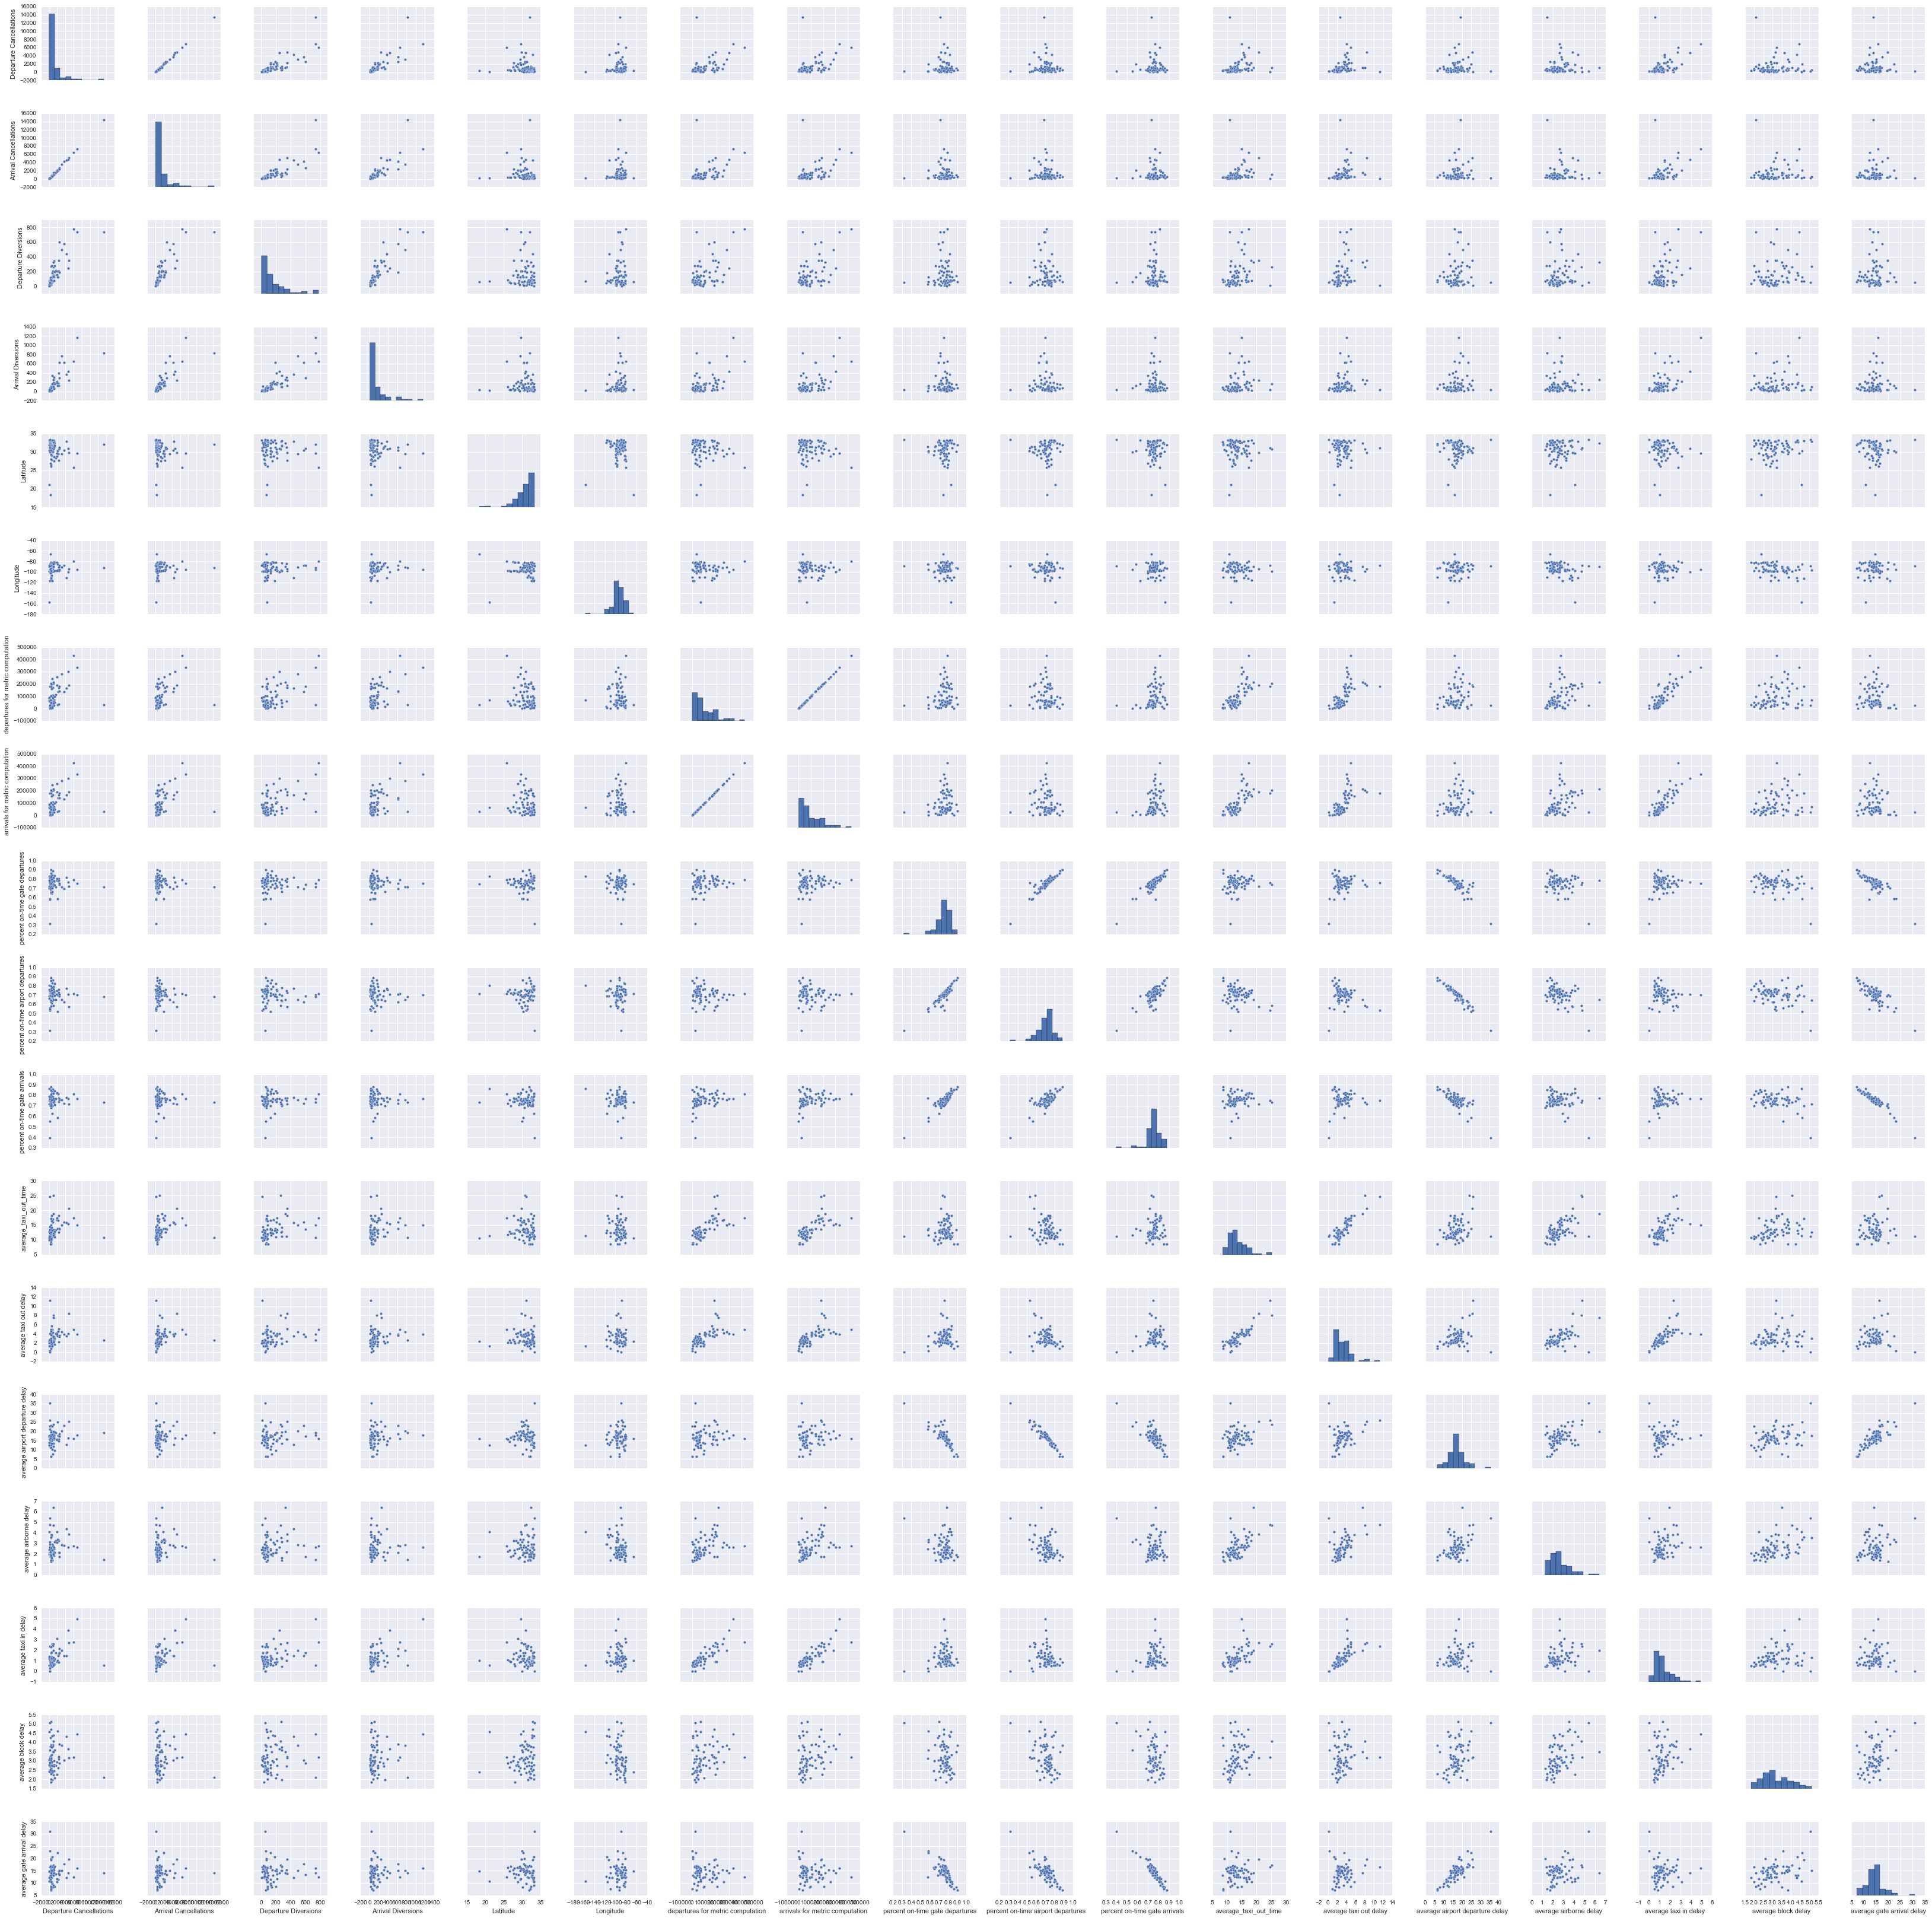

In [41]:
sns.pairplot(dfn, kind="scatter")

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: 

#### 4.4 Validate your findings using statistical analysis

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: Perform a PCA

#### 5.1 Conduct the PCA

In [42]:
# dfp = pd.DataFrame(df)
# dfp.pop('ap_type')
# dfp.pop('region')
# dfp.pop('LocID')
# dfp.head()

In [43]:
x = dfn.ix[:,1:].values
y = dfn.ix[:,0].values

In [44]:
xStand = StandardScaler().fit_transform(x)

In [45]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [46]:
print(eigenValues)
print(eigenVectors)

[  5.49688369e+00   4.72559649e+00   2.25537830e+00   1.38488741e+00
   1.01825842e+00   7.14989902e-01   4.37245057e-01   4.02629396e-01
   2.41989784e-01   1.86917035e-01   1.51447044e-01   1.06949423e-01
   7.24237866e-02   3.46949368e-02   6.75146645e-03   2.35582086e-03
   3.86562625e-05]
[[ -2.29643814e-01  -1.25165830e-01   4.39978382e-01  -1.34799827e-01
    5.18349954e-02  -3.49111206e-01   6.21068848e-02  -1.48235488e-01
   -1.67469053e-01   1.00403457e-01   7.18052262e-01   9.80087555e-02
    3.40920673e-04  -7.69945896e-02  -9.91105700e-03  -9.35118282e-03
   -1.80997910e-03]
 [ -2.63907505e-01  -1.37101327e-01   4.05909220e-01  -1.66645318e-01
    3.52420508e-02  -2.09888491e-01  -1.73458321e-01   1.60906587e-01
    1.12146503e-01  -2.46448030e-01  -2.97629281e-01  -6.64517405e-01
    1.12725304e-01  -3.94253125e-02  -6.01898181e-04   1.42077420e-03
   -2.32991929e-03]
 [ -2.58370398e-01  -1.29424168e-01   4.38509092e-01  -1.84844436e-01
    2.10812051e-02  -1.75606291e-02

In [47]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

5.49688369283
4.72559649263
2.25537829552
1.3848874055
1.0182584231
0.714989902097
0.437245056906
0.402629396489
0.241989784446
0.186917035451
0.151447044478
0.106949423315
0.0724237865617
0.0346949368193
0.00675146644644
0.00235582085842
3.86562625479e-05


In [48]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

In [49]:
print(cumulvarExpl)

[  31.88551815   59.29706644   72.37973465   80.41298676   86.31955114
   90.46695989   93.003267     95.33878066   96.74247957   97.82672054
   98.70521238   99.32558894   99.74569424   99.94694755   99.98611047
   99.99977577  100.        ]


In [50]:
airports_pca = PCA(n_components=3)
airports_pca.fit(xStand)
X = airports_pca.transform(xStand)

airports_pca.components_
# components_.X


array([[ 0.22964381,  0.2639075 ,  0.2583704 , -0.0141587 ,  0.00454679,
         0.34775304,  0.34794463, -0.11950909, -0.23673566, -0.07706393,
         0.3260877 ,  0.30795874,  0.25924055,  0.26182159,  0.31751775,
         0.18197762,  0.14668365],
       [ 0.12516583,  0.13710133,  0.12942417, -0.03736641, -0.01179942,
         0.21502197,  0.21423815,  0.41312311,  0.35827092,  0.43130617,
         0.08681061,  0.11633156, -0.34661116, -0.10594264,  0.18551093,
        -0.15057676, -0.40068009],
       [-0.43997838, -0.40590922, -0.43850909,  0.06398054, -0.2762625 ,
         0.05699161,  0.05573657,  0.13049978, -0.00071288,  0.11337535,
         0.30138328,  0.28318159, -0.01592086,  0.35760911,  0.04631451,
         0.161878  , -0.07212338]])

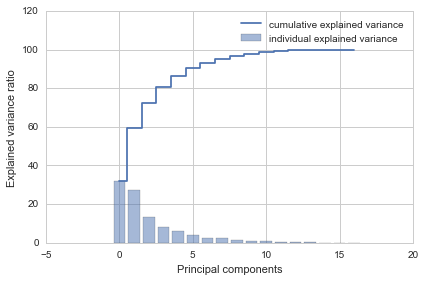

In [51]:
from matplotlib import pyplot as plt
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(cumulvarExpl)), varExpl, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(cumulvarExpl)), cumulvarExpl, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

Which operational features are most correlated with delays?

What should the airport's next steps be?

### Bonus: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied